In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import pyccl as ccl
import pyccl.nl_pt as pt
import pyccl.ccllib as lib

plt.rcParams['axes.labelsize']        = 12
plt.rcParams['axes.titlesize']        = 12
plt.rcParams['xtick.labelsize']       = 12
plt.rcParams['ytick.labelsize']       = 12
plt.rcParams['font.family']           = 'serif'
plt.rcParams['font.size']             = 12

In [2]:
h = 0.68
cosmo = ccl.Cosmology(Omega_c=0.25337, Omega_b=0.04933, h=h, A_s=2e-9, n_s=0.96, transfer_function='boltzmann_class')
a_1 = 1.

### Intrinsic Alignments

In [3]:
# IA Normalization
z = np.linspace(0,4,128)
gz = ccl.growth_factor(cosmo, 1./(1+z))

Om_m = cosmo['Omega_m']
rho_crit = lib.cvar.constants.RHO_CRITICAL
rho_m = lib.cvar.constants.RHO_CRITICAL * cosmo['Omega_m']

c_1_t = c_1 = -1*a_1*5e-14*rho_crit*cosmo['Omega_m']/gz


In [4]:
# Intrinsic alignments
ptt_i_nla = pt.PTIntrinsicAlignmentTracer(c1=(z,c_1))
ptt_m = pt.PTMatterTracer()

In [5]:
# The `with_NC` and `with_IA` flags will tell FastPT to initialize the right things.
# `log10k_min/max and nk_per_decade will define the sampling in k you should use.

ptc = pt.EulerianPTCalculator(with_NC=False, with_IA=True,
                      log10k_min=-3, log10k_max=4, nk_per_decade=20)

ptc.update_ingredients(cosmo)

Warning, you selected a extrap_high that is less than k_max. Therefore no extrapolation will be done.


In [6]:
kk = np.logspace(-3,1)
z = np.linspace(0, 4)
pk_mm_NL = ccl.power.nonlin_matter_power(cosmo, k=kk, a=(1/(1+z))[::-1])
pk_mm = ccl.pk2d.Pk2D(a_arr=1/(1+z)[::-1], lk_arr=np.log(kk), pk_arr=pk_mm_NL, is_logp=False)

In [7]:
# IAs X IAs
pk_ii_nla = ptc.get_biased_pk2d(ptt_i_nla, tracer2=ptt_i_nla)
# IAs X matter
pk_im = ptc.get_biased_pk2d(ptt_i_nla, tracer2=ptt_m)

In [8]:
src_LSSTs = np.loadtxt('surveys/nz_lsst_5sbins.txt', unpack=True)
z_src_LSST = src_LSSTs[0]
dndz_src_LSST = src_LSSTs[-2]
dndz_src_LSST_2 = src_LSSTs[-1]

t_l = ccl.WeakLensingTracer(cosmo, dndz=(z_src_LSST, dndz_src_LSST), has_shear=True)
t_l2 = ccl.WeakLensingTracer(cosmo, dndz=(z_src_LSST, dndz_src_LSST_2), has_shear=True)

t_i_nla = ccl.WeakLensingTracer(cosmo, dndz=(z_src_LSST, dndz_src_LSST), has_shear=True, ia_bias=(z, np.ones_like(z)), use_A_ia=False)
t_i_nla2 = ccl.WeakLensingTracer(cosmo, dndz=(z_src_LSST, dndz_src_LSST_2), has_shear=True, ia_bias=(z, np.ones_like(z)), use_A_ia=False)

In [9]:
ell = np.arange(2,2e3+1)
cls={}
cls['GG'] = ccl.angular_cl(cosmo, t_l, t_l, ell, p_of_k_a=pk_mm)
cls['GI,NLA'] = ccl.angular_cl(cosmo, t_l, t_i_nla, ell, p_of_k_a=pk_im)
cls['II,NLA'] = ccl.angular_cl(cosmo, t_i_nla, t_i_nla, ell, p_of_k_a=pk_ii_nla)

cls['GG_cross'] = ccl.angular_cl(cosmo, t_l, t_l2, ell, p_of_k_a=pk_mm)
cls['GI,NLA_cross'] = ccl.angular_cl(cosmo, t_l2, t_i_nla, ell, p_of_k_a=pk_im)
cls['II,NLA_cross'] = ccl.angular_cl(cosmo, t_i_nla2, t_i_nla, ell, p_of_k_a=pk_ii_nla)

### Photo-zs ###

In [10]:
zarr = np.linspace(0,4)
desi_mu = 0.633
desi_std = 0.077
desi_dndz = np.exp(-((zarr-desi_mu)/(desi_std))**2)
desi_shotnoise = 1/(311 * 3282.8) # 2D shot noise
desi_b = 2
DESI_fsky = 0.4

In [11]:
# Number counts
b_1 = desi_b
ptt_g = pt.PTNumberCountsTracer(b1=b_1, b2=0.9, bs=-1.8, bk2=-0.49)
ptc = pt.EulerianPTCalculator(with_NC=True, with_IA=False, log10k_min=-4, log10k_max=2, nk_per_decade=20)
ptc.update_ingredients(cosmo)

pk_gg = ptc.get_biased_pk2d(ptt_g, tracer2=ptt_g)
pk_gm = ptc.get_biased_pk2d(ptt_g, tracer2=ptt_m)

t_g = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(zarr, desi_dndz), bias=(zarr, np.ones_like(zarr)), mag_bias=None)
t_cmb = ccl.CMBLensingTracer(cosmo, z_source=1088)
t_source = ccl.WeakLensingTracer(cosmo, dndz=(z_src_LSST, dndz_src_LSST))

clgg_DESI = ccl.angular_cl(cosmo, t_g, t_g, ell, p_of_k_a=pk_gg)
clkg_cmb = ccl.angular_cl(cosmo, t_g, t_cmb, ell, p_of_k_a=pk_gm)
clkk_cmb = ccl.angular_cl(cosmo, t_cmb, t_cmb, ell, p_of_k_a=pk_mm)

clkg_gal = ccl.angular_cl(cosmo, t_g, t_source, ell, p_of_k_a=pk_gm)
clkk_gal = ccl.angular_cl(cosmo, t_source, t_source, ell, p_of_k_a=pk_mm)


In [12]:
sigma_z = 0.015
t_source_2 = ccl.WeakLensingTracer(cosmo, dndz=(z_src_LSST+sigma_z, dndz_src_LSST))

clkg_gal_2 = ccl.angular_cl(cosmo, t_g, t_source_2, ell, p_of_k_a=pk_gm)
clkk_gal_2 = ccl.angular_cl(cosmo, t_source_2, t_source_2, ell, p_of_k_a=pk_mm)


### Baryons ###

In [13]:
z = np.linspace(0, 10)
kk, meas_cowls, A_mod_cowls, taylor_cowls = np.loadtxt('baryon_spectra/baryons_cowls.txt', unpack=True)

In [14]:
kk_ext = np.concatenate((np.logspace(-3,-2), kk*h))
A_mod_cowls_ext = np.concatenate((np.ones(50), A_mod_cowls))

In [ ]:
pk_mm_NL = ccl.power.nonlin_matter_power(cosmo, k=kk_ext, a=(1/(1+z))[::-1])
pk2d_cowls = ccl.pk2d.Pk2D(a_arr=1/(1+z)[::-1], lk_arr=np.log(kk_ext), pk_arr=A_mod_cowls_ext*pk_mm_NL, is_logp=False)

# 10% shift in c_2 and c_4 given R_b = 1.25
err_fac = 1+(0.1*(kk_ext*1.25*h)**2)/(1+0.1*(kk_ext*1.25*h)**2)
pk2d_cowls_2 = ccl.pk2d.Pk2D(a_arr=1/(1+z)[::-1], lk_arr=np.log(kk_ext), pk_arr=err_fac*A_mod_cowls_ext*pk_mm_NL, is_logp=False)

In [ ]:
clgg_DESI_cowls = ccl.angular_cl(cosmo, t_g, t_g, ell, p_of_k_a=desi_b**2*pk2d_cowls)
clgg_DESI_cowls_2 = ccl.angular_cl(cosmo, t_g, t_g, ell, p_of_k_a=desi_b**2*pk2d_cowls_2)

### Scale-Dependent Bias ###

In [ ]:
k = kk_ext[:-17]
pgg_fid = h**3*pk_gg(k*h, 1/(1+0.633))+1e3
pgm_fid = h**3*pk_gm(k*h, 1/(1+0.633))

In [ ]:
import numpy as np
from aemulus_heft.heft_emu import HEFTEmulator
from aemulus_heft.utils import lpt_spectra

emu = HEFTEmulator()
cosmology = [0.022810192, 0.117162912, -1, 0.96, 2., h*100, 0.]
z=0.633

spec_lpt, sigma8z = lpt_spectra(k, z, cosmology)
cosmology.append(sigma8z)
spec_heft = emu.predict(k, np.array(cosmology), spec_lpt)

In [ ]:
def bias_fit(biases, emu, spec_heft):
    phh_dat = pgg_fid
    phm_dat = pgm_fid
    
    phh_fit = emu.basis_to_full(k, biases, spec_heft, cross=False)
    phm_fit = emu.basis_to_full(k, biases, spec_heft, cross=True)

    idx = -1
    chisq = np.sum((phh_dat[:idx]-phh_fit[:idx])**2/(phh_fit[:idx])) + \
            np.sum((phm_dat[:idx]-phm_fit[:idx])**2/(phm_fit[:idx])) + \
            np.sum(k[idx:]**2*(phh_dat[idx:]-phh_fit[idx:])**2/(phh_fit[idx:])) + \
            np.sum(k[idx:]**2*(phm_dat[idx:]-phm_fit[idx:])**2/(phm_fit[idx:]))

    return chisq


def bias_fit_lin(biases, emu, spec_heft):
    b1, sn = biases
    phh_dat = pgg_fid
    phm_dat = pgm_fid
    
    phh_fit = emu.basis_to_full(k, [b1, 0, 0, 0, sn], spec_heft, cross=False)
    phm_fit = emu.basis_to_full(k, [b1, 0, 0, 0, sn], spec_heft, cross=True)

    idx = -60  #k[-60] = 0.2
    chisq = np.sum((phh_dat[:idx]-phh_fit[:idx])**2/(phh_fit[:idx])) + np.sum((phm_dat[:idx]-phm_fit[:idx])**2/(phm_fit[:idx]))
    
    return chisq

In [21]:
fit = sc.optimize.minimize(bias_fit, x0=[0.9, -0.7, -0.4, 0.14, -100], args=(emu, spec_heft))['x']
fit_lin = sc.optimize.minimize(bias_fit_lin, x0=[0.9, -100], args=(emu, spec_heft))['x']
# b1, b2, bs, bk2, sn
print(fit)
print(fit_lin)

[ 9.97478271e-01  6.33066447e-01 -1.01542154e-01  5.75905077e-01
  9.44839711e+02]
[9.92189163e-01 1.27622074e+03]


In [22]:
phh_quad = emu.basis_to_full(k, fit, spec_heft, cross=False)
phm_quad = emu.basis_to_full(k, fit, spec_heft, cross=True)

phh_lin = emu.basis_to_full(k, [fit_lin[0], 0, 0, 0, fit_lin[-1]], spec_heft, cross=False)
phm_lin = emu.basis_to_full(k, [fit_lin[0], 0, 0, 0, fit_lin[-1]], spec_heft, cross=True)

In [23]:
clkg_gal = ccl.angular_cl(cosmo, t_g, t_source, ell, p_of_k_a=pk_gm)
clkk_gal = ccl.angular_cl(cosmo, t_source, t_source, ell, p_of_k_a=pk_mm)

In [ ]:
pgg_quads = []
pgm_quads = []

pgg_lins = []
pgm_lins = []

# Takes about 1 minute
zs = np.linspace(0, 4, 20)
for z in zs:
    cosmology = [0.022810192, 0.117162912, -1, 0.96, 2., h*100, 0.]
    spec_lpt, sigma8z = lpt_spectra(k, z, cosmology)
    cosmology.append(sigma8z)
    spec_heft = emu.predict(k, np.array(cosmology), spec_lpt)
    phh_quad_temp = emu.basis_to_full(k, fit, spec_heft, cross=False)
    pgg_quads.append(phh_quad_temp)
    phm_quad_temp = emu.basis_to_full(k, fit, spec_heft, cross=True)
    pgm_quads.append(phm_quad_temp)
    phh_lin_temp = emu.basis_to_full(k, [fit_lin[0], 0, 0, 0, fit_lin[-1]], spec_heft, cross=False)
    pgg_lins.append(phh_lin_temp)
    phm_lin_temp = emu.basis_to_full(k, [fit_lin[0], 0, 0, 0, fit_lin[-1]], spec_heft, cross=True)
    pgm_lins.append(phm_lin_temp)


In [25]:
pgg_quads = pgg_quads[::-1]
pgm_quads = pgm_quads[::-1]
pgg_lins = pgg_lins[::-1]
pgm_lins = pgm_lins[::-1]

In [26]:
pgg_quad = ccl.pk2d.Pk2D(a_arr=1/(1+zs)[::-1], lk_arr=np.log(k/h), pk_arr=np.array(pgg_quads), is_logp=False)
pgm_quad = ccl.pk2d.Pk2D(a_arr=1/(1+zs)[::-1], lk_arr=np.log(k/h), pk_arr=np.array(pgm_quads), is_logp=False)
pgg_lin = ccl.pk2d.Pk2D(a_arr=1/(1+zs)[::-1], lk_arr=np.log(k/h), pk_arr=np.array(pgg_lins), is_logp=False)
pgm_lin = ccl.pk2d.Pk2D(a_arr=1/(1+zs)[::-1], lk_arr=np.log(k/h), pk_arr=np.array(pgm_lins), is_logp=False)

In [27]:
# CMB lensing
clgg_quad = ccl.angular_cl(cosmo, t_g, t_g, ell, p_of_k_a=pgg_quad)
clgk_quad_ggl = ccl.angular_cl(cosmo, t_g, t_source, ell, p_of_k_a=pgm_quad)
clgg_lin = ccl.angular_cl(cosmo, t_g, t_g, ell, p_of_k_a=pgg_lin)
clgk_lin_ggl = ccl.angular_cl(cosmo, t_g, t_source, ell, p_of_k_a=pgm_lin)

### All ###

In [28]:
chi = h*ccl.background.comoving_radial_distance(cosmo, 1/(1+0.633))

def k2ell(k):
    return k*chi - 0.5

def ell2k(ell):
    return (ell+0.5)/chi


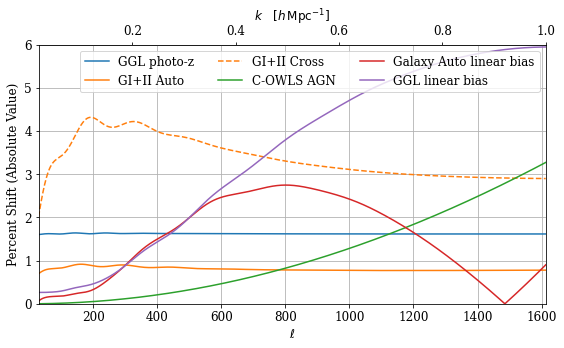

In [30]:
fig, ax = plt.subplots(figsize=(8,5))

ax.plot(ell, 100*abs(clkg_gal_2-clkg_gal)/clkg_gal, label='GGL photo-z')
ax.plot(ell, 100*abs(cls['GI,NLA']+cls['II,NLA'])/cls['GG'], label='GI+II Auto')
ax.plot(ell, 100*abs(cls['GI,NLA_cross']+cls['II,NLA_cross'])/cls['GG_cross'], label='GI+II Cross', c='C1', ls='--')

ax.plot(ell, 100*abs(clgg_DESI_cowls_2-clgg_DESI_cowls)/clgg_DESI_cowls, label='C-OWLS AGN')

ax.plot(ell, 100*abs(clgg_quad-clgg_lin)/clgg_quad, label='Galaxy Auto linear bias')
ax.plot(ell, 100*abs(clgk_quad_ggl-clgk_lin_ggl)/clgk_quad_ggl, label='GGL linear bias')
         
ax.legend(ncol=3)
ax.set_ylim(0, 6)
ax.set_xlim(30, 1*chi-0.5)
secax = ax.secondary_xaxis('top', functions=(ell2k, k2ell))
secax.set_xlabel(r'$k\quad[h\,{\rm Mpc}^{-1}]$')
ax.grid()
ax.set_xlabel(r'$\ell$')
ax.set_ylabel('Percent Shift (Absolute Value)')
fig.tight_layout()
fig.savefig('figures/systematic_err_abs.pdf')
